In [1]:
!pip install -q scikit-image scipy

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
import torch
import numpy as np, cv2, math, random, os, glob, csv
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import skeletonize
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
from skimage.morphology import skeletonize
from google.colab import files
from tqdm import tqdm

In [3]:
!unzip tiles_images.zip

Archive:  tiles_images.zip
   creating: tiles_images/
   creating: tiles_images/images/
  inflating: tiles_images/images/image_0038.png  
  inflating: tiles_images/images/image_0046.png  
  inflating: tiles_images/images/image_0048.png  
 extracting: tiles_images/images/image_0050.png  
 extracting: tiles_images/images/image_0052.png  
 extracting: tiles_images/images/image_0054.png  
  inflating: tiles_images/images/image_0056.png  
 extracting: tiles_images/images/image_0058.png  
  inflating: tiles_images/images/image_0060.png  
  inflating: tiles_images/images/image_0064.png  
 extracting: tiles_images/images/image_0066.png  
 extracting: tiles_images/images/image_0068.png  
  inflating: tiles_images/images/image_0070.png  
  inflating: tiles_images/images/image_0072.png  
 extracting: tiles_images/images/image_0074.png  
  inflating: tiles_images/images/image_0078.png  
 extracting: tiles_images/images/image_0086.png  
 extracting: tiles_images/images/image_0088.png  
  inflating:

In [81]:
class CurveDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, '*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']
        return img

In [83]:
ds = CurveDataset("/content/tiles_images/images")

/tmp/ipython-input-88-3927364849.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  A, θ, y0 = curve_fit(model, xs, ys, p0=guess, maxfev=5000)[0]


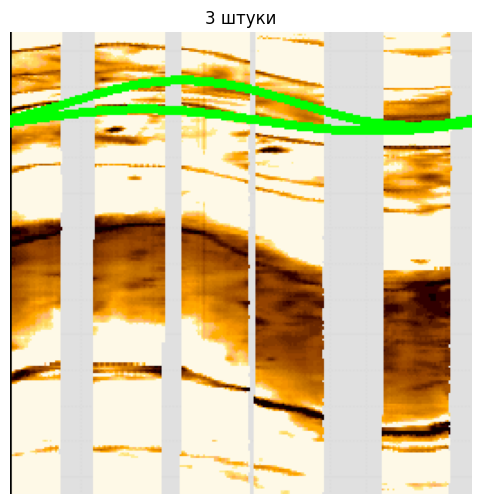

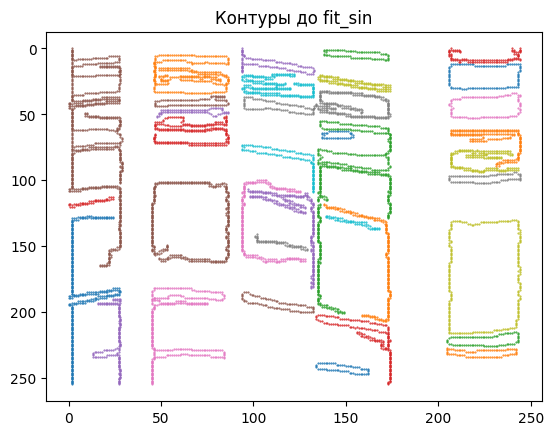

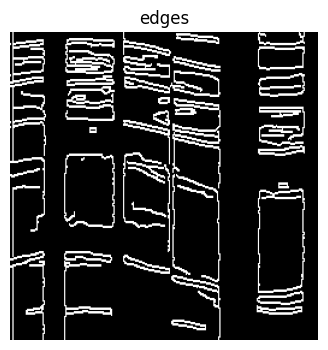

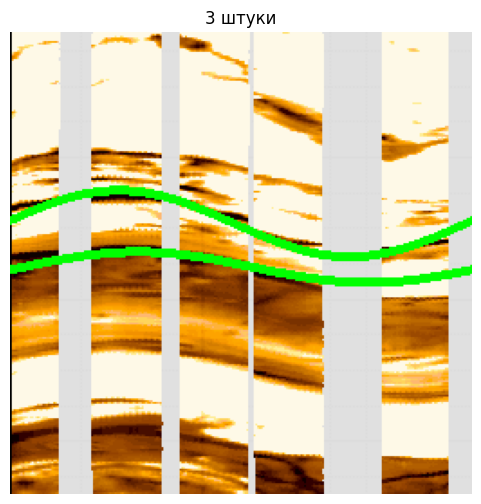

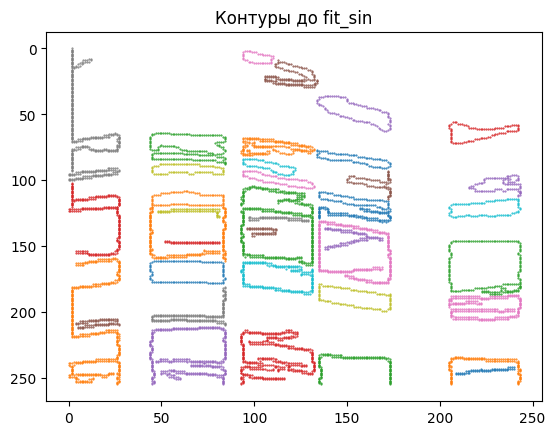

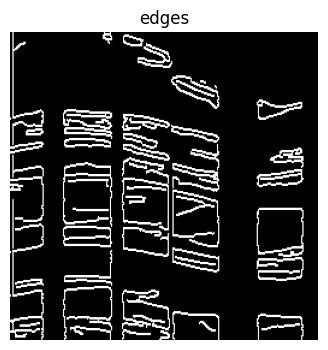

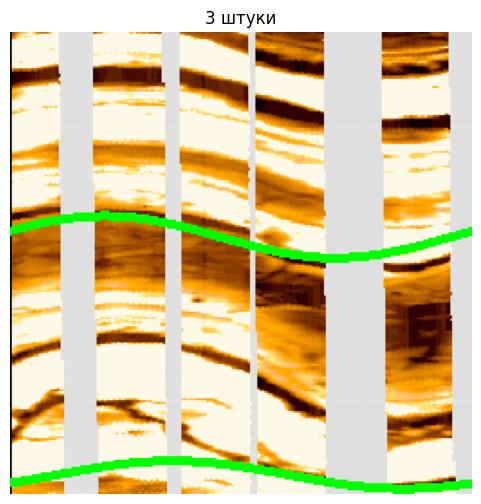

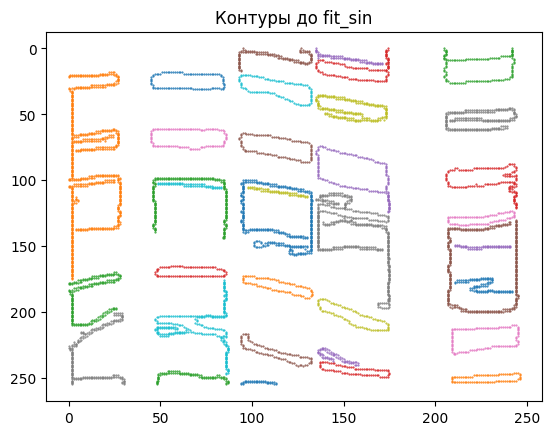

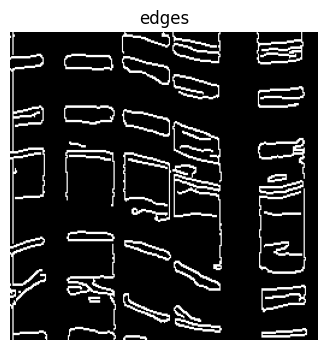

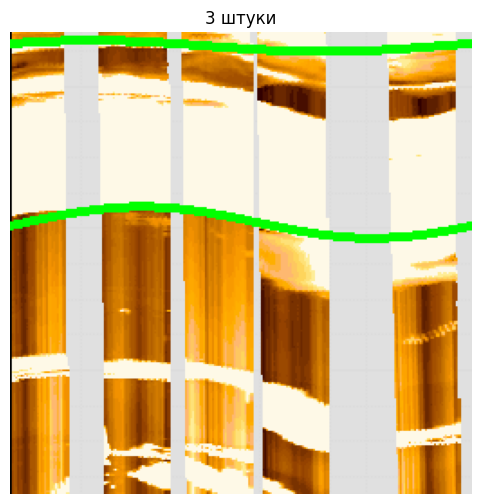

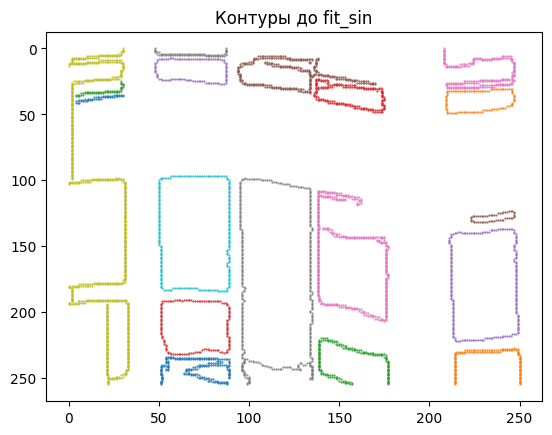

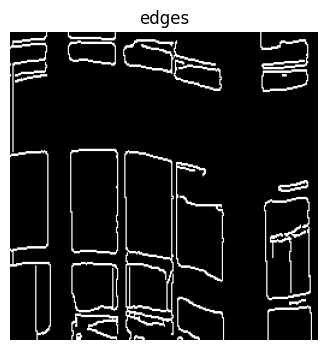

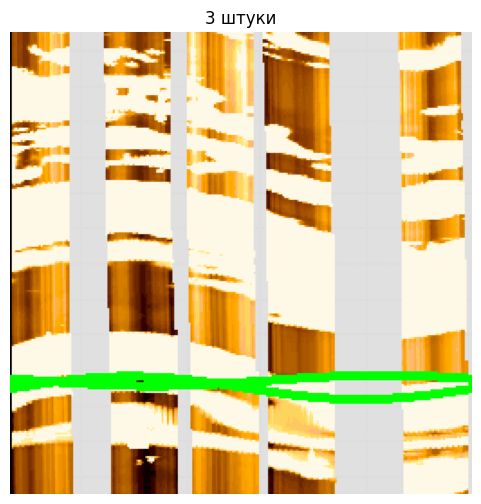

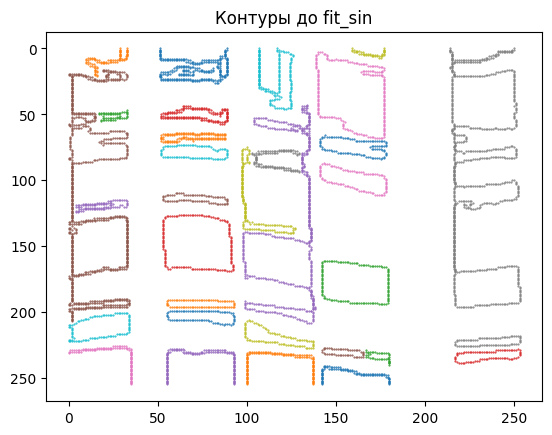

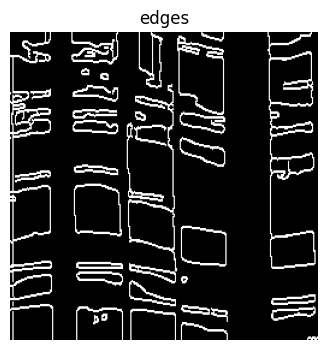

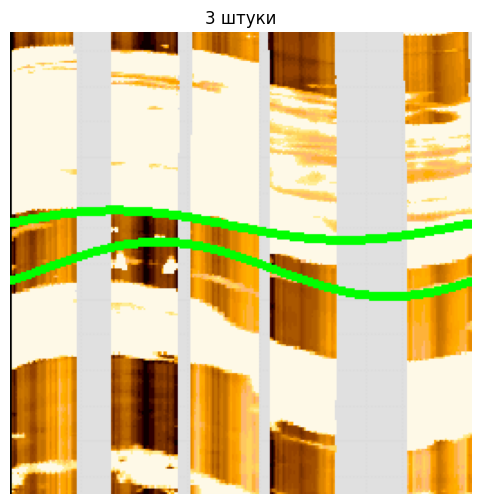

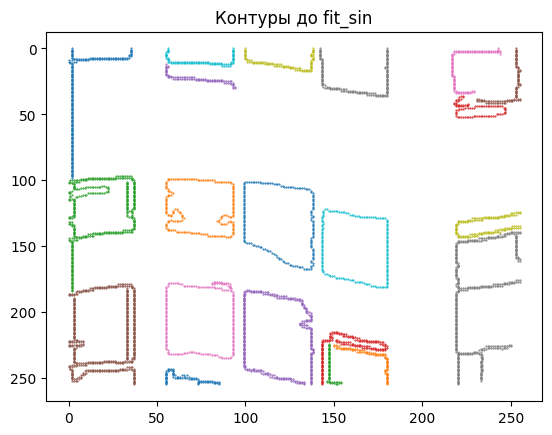

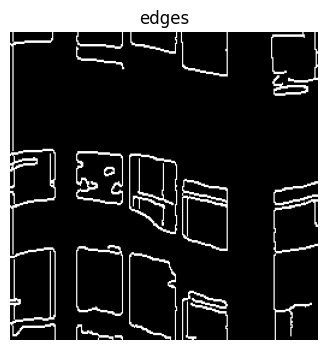

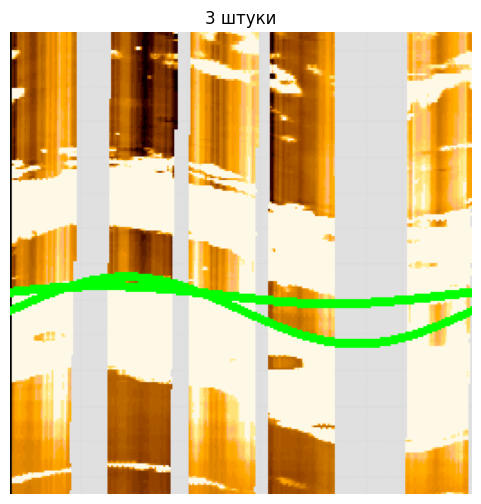

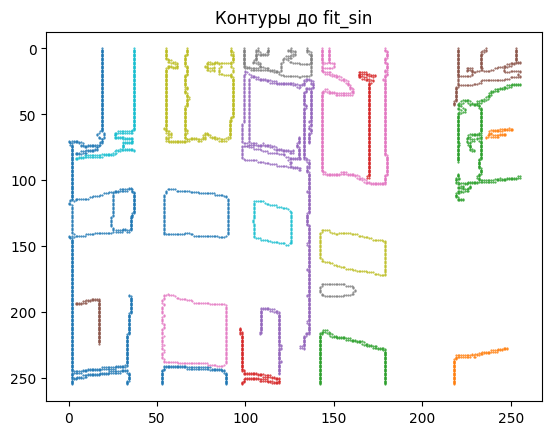

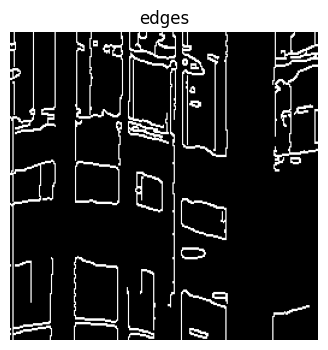

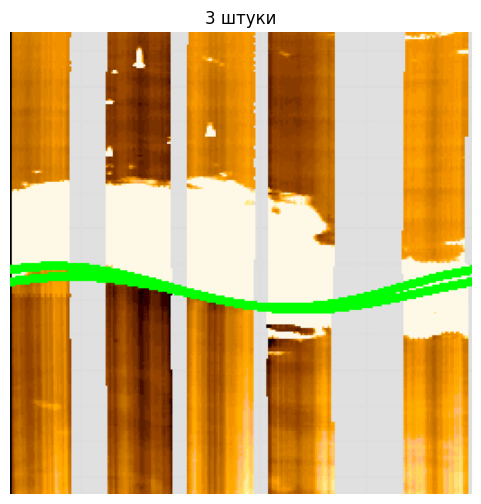

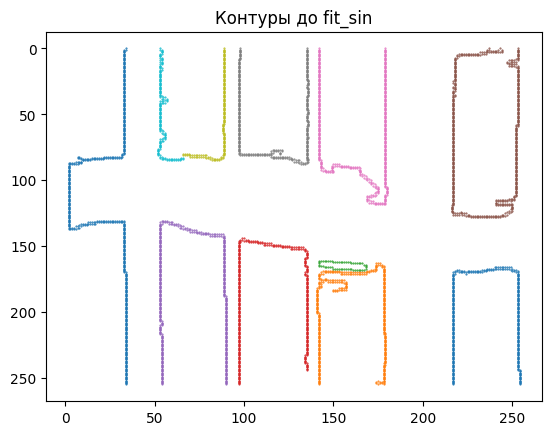

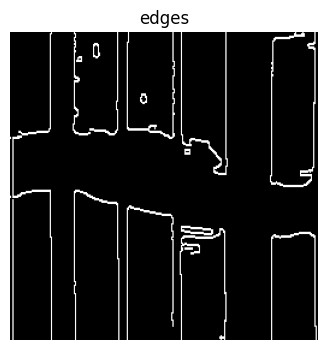

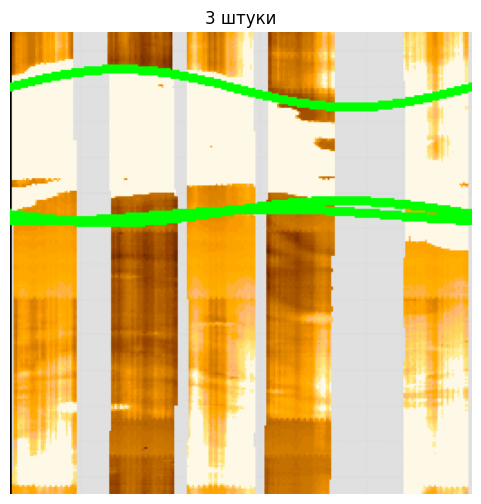

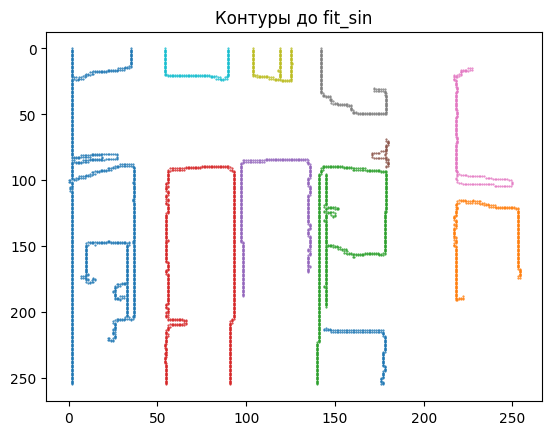

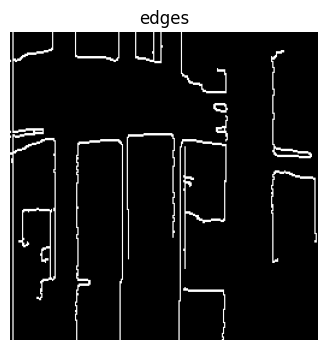

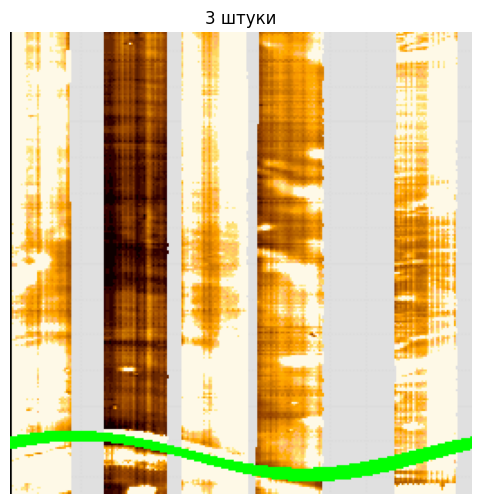

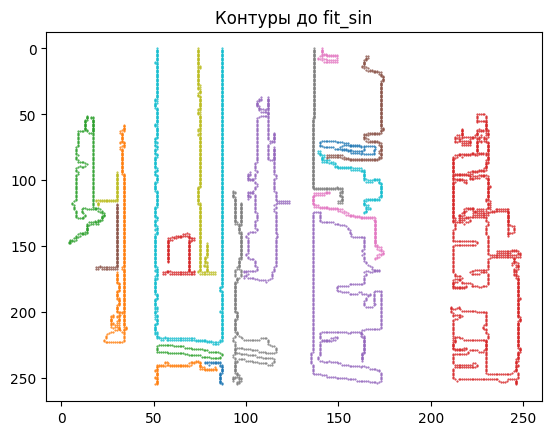

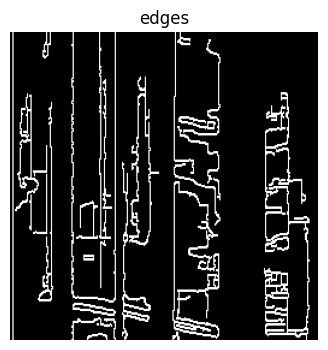

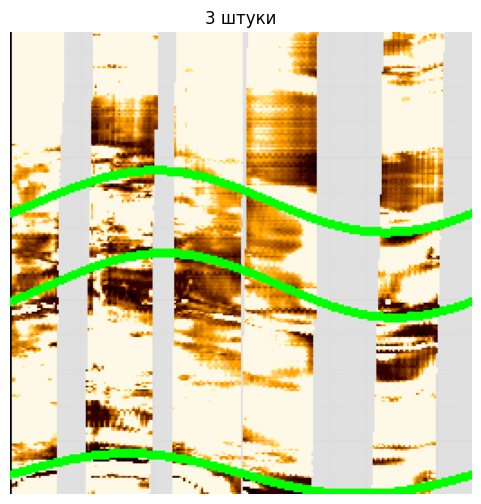

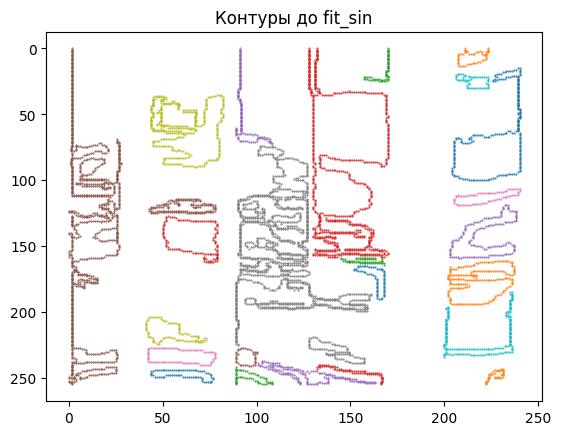

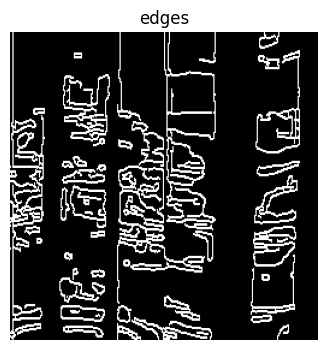

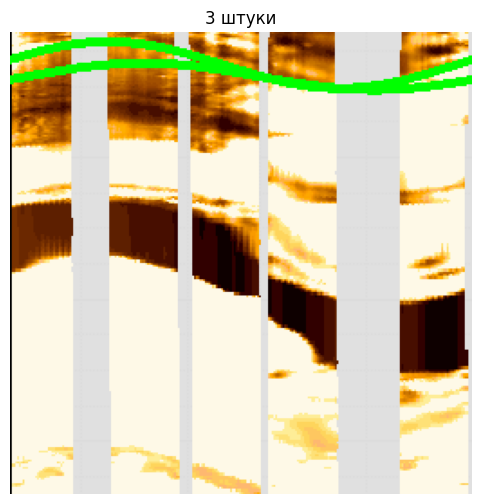

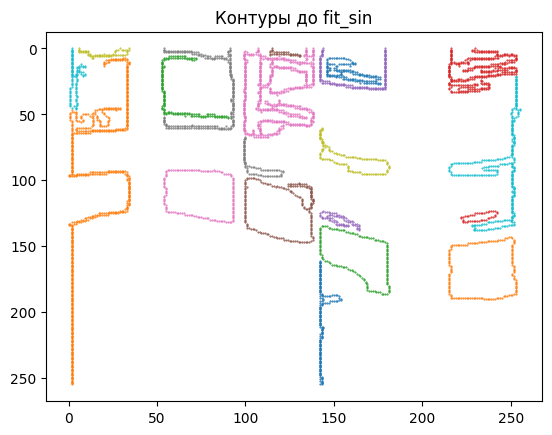

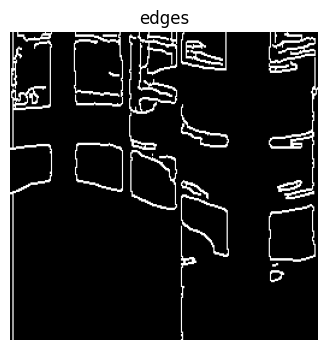

In [88]:
ω = None

def contours_from_mask(mask, min_len=50, min_span_ratio=0.1):
    h, w = mask.shape
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    good=[]
    for c in cnts:
        if len(c) < min_len:
          continue
        if np.ptp(c[:,0,0]) / w < min_span_ratio:
          continue
        good.append(c[:,0,:])
    return good

def fit_sinusoid(points, ω, h, guess=None, max_pts=2000):
    points = np.asarray(points)
    xs, ys = points[:, 0], points[:, 1]

    if len(xs) > max_pts:
        sel = np.random.choice(len(xs), max_pts, replace=False)
        xs, ys = xs[sel], ys[sel]

    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]

    ys = median_filter(ys, size=5)

    if guess is None:
        guess = (np.ptp(ys)/2, 0.0, ys.mean())

    def model(x, A, θ, y0):
        return A * np.sin(ω * x + θ) + y0

    try:
        A, θ, y0 = curve_fit(model, xs, ys, p0=guess, maxfev=5000)[0]
        if A < 0:
            A = -A
            θ = (θ + math.pi) % (2 * math.pi)
        return A, θ, y0
    except RuntimeError:
        return None

def split_upper_lower(pts: np.ndarray, min_x_span: int = 50):
    xs, ys = pts[:, 0], pts[:, 1]
    uniq_x = np.unique(xs)
    if np.ptp(uniq_x) < min_x_span:
        return []
    upper, lower = [], []
    for x in uniq_x:
        ys_here = ys[xs == x]
        upper.append((x, ys_here.min()))
        lower.append((x, ys_here.max()))
    return [np.array(upper), np.array(lower)]

def preprocess(img_rgb, low_thresh=0.1, high_thresh=0.6):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred = cv2.GaussianBlur(gray, (5,5), 1.41)
    edges = cv2.Canny(blurred, int(low_thresh * 255), int(high_thresh*255), apertureSize=3, L2gradient=True)
    edges = cv2.dilate(edges, (3, 3), iterations=1)
    return edges

def preprocess_edges_dark_light_version(img_rgb, low_thresh=0.1, high_thresh=0.6):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred = cv2.GaussianBlur(thresh_img, (5,5), 1.41)
    edges = cv2.Canny(blurred, int(low_thresh * 255), int(high_thresh*255), apertureSize=3, L2gradient=True)
    edges = cv2.dilate(edges, (3, 3), iterations=1)
    return edges

def preprocess_edges_dark(img_rgb, low_thresh=0.1, high_thresh=0.6):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 1.41)
    edges = cv2.Canny(blurred, int(low_thresh * 255), int(high_thresh*255), apertureSize=3, L2gradient=True)
    edges = cv2.dilate(edges, (3, 3), iterations=1)
    return edges

def detect_and_draw(img_rgb,
                    background="rgb",
                    top_N=3,
                    rms_thr=10.0,
                    min_len=40,
                    span_ratio=0.03,
                    show_debug=False):

    h, w = img_rgb.shape[:2]
    ω = 2 * np.pi / w

    edges_dark = preprocess_edges_dark(img_rgb)
    edges_light = preprocess_edges_dark_light_version(img_rgb)
    edges = preprocess(img_rgb)

    contours_dark = contours_from_mask(edges_dark, min_len, span_ratio)
    contours_light = contours_from_mask(edges_light, min_len, span_ratio)
    contours = contours_from_mask(edges, min_len, span_ratio)

    scored = []

    for cnt in contours_dark:
        for pts in split_upper_lower(cnt, min_x_span=30):
            if len(pts) < 30:
                continue

            fit = fit_sinusoid(pts, ω, h)
            if fit is None:
                continue
            A, θ, y0 = fit

            if A < 2 or A > h / 1.5:
                continue

            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A*np.sin(ω*xs + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue

            geom = len(pts) / rmse
            if A > 200:
              continue

            scored.append((geom, A, θ, y0))

    for cnt in contours_light:
        for pts in split_upper_lower(cnt, min_x_span=30):
            if len(pts) < 30:
                continue

            fit = fit_sinusoid(pts, ω, h)
            if fit is None:
                continue
            A, θ, y0 = fit

            if A < 2 or A > h / 1.5:
                continue

            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A*np.sin(ω*xs + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue

            geom = len(pts) / rmse
            if A > 200:
                continue
            scored.append((geom, A, θ, y0))

    for cnt in contours:
        for pts in split_upper_lower(cnt, min_x_span=30):
            if len(pts) < 30:
                continue

            fit = fit_sinusoid(pts, ω, h)
            if fit is None:
                continue
            A, θ, y0 = fit

            if A < 2 or A > h / 1.5:
                continue

            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A*np.sin(ω*xs + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue

            geom = len(pts) / rmse
            if A > 200:
                continue
            scored.append((geom, A, θ, y0))

    scored.sort(key=lambda t: t[0], reverse=True)
    curves = [(A, θ, y0) for _, A, θ, y0 in scored[:top_N]]

    canvas_1 = cv2.cvtColor(edges_dark, cv2.COLOR_GRAY2BGR) if background == "mask" else img_rgb.copy()
    canvas_2 = cv2.cvtColor(edges_light, cv2.COLOR_GRAY2BGR) if background == "mask" else img_rgb.copy()
    canvas_3 = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR) if background == "mask" else img_rgb.copy()

    xs_full = np.arange(w)
    for A, θ, y0 in curves:
        ys = (A * np.sin(ω*xs_full + θ) + y0).astype(int)
        good = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[good], ys[good]]).astype(np.int32)
        cv2.polylines(canvas_1, [pts], False, (0, 255, 0), 3)

    for A, θ, y0 in curves:
        ys = (A * np.sin(ω*xs_full + θ) + y0).astype(int)
        good = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[good], ys[good]]).astype(np.int32)
        cv2.polylines(canvas_2, [pts], False, (0, 255, 0), 3)

    for A, θ, y0 in curves:
        ys = (A * np.sin(ω*xs_full + θ) + y0).astype(int)
        good = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[good], ys[good]]).astype(np.int32)
        cv2.polylines(canvas_3, [pts], False, (0, 255, 0), 3)

    plt.figure(figsize=(6, 6))

    plt.imshow(canvas_1)
    plt.imshow(canvas_2)
    plt.imshow(canvas_3)

    plt.axis("off")
    plt.title(f"{len(curves)} штуки")
    plt.show()

    for c in contours:
        plt.plot(c[:, 0], c[:, 1], '.', markersize=1)
    plt.gca().invert_yaxis()
    plt.title("Контуры до fit_sin")
    plt.show()

    if show_debug:
        plt.figure(figsize=(4, 4))

        plt.imshow(edges_dark, cmap="gray")
        plt.imshow(edges_light, cmap="gray")
        plt.imshow(edges, cmap="gray")

        plt.axis("off")
        plt.title("edges")
        plt.show()


for i in range (49, 59 + 1):
    sample_path = ds.imgs[i]
    img = np.array(Image.open(sample_path).convert('RGB'))
    detect_and_draw(img_rgb=img, show_debug=True)

sample_path = ds.imgs[100]
img = np.array(Image.open(sample_path).convert('RGB'))
detect_and_draw(img_rgb=img, show_debug=True)


In [89]:
def draw_sine(img, A, θ, y0, ω, color=(0, 255, 0), thickness=3):
    h, w = img.shape[:2]
    xs = np.arange(w)
    ys = (A * np.sin(ω * xs + θ) + y0).astype(int)
    mask = (ys >= 0) & (ys < h)
    pts = np.column_stack([xs[mask], ys[mask]]).astype(np.int32)
    if len(pts) > 1:
        cv2.polylines(img, [pts], isClosed=False, color=color, thickness=thickness)

In [90]:
colors_parth = "/content/colors.csv" #размеченные данные (-1 = лишняя кривая, 1 = подходящая)

In [91]:
df = pd.read_csv(colors_parth, sep=r',|;', engine='python')
df['color'] = df['color'].apply(lambda x: 1 if x in [1, 2, 5, 6] else -1)

In [92]:
df

,depth_m,A_mm,theta_rad,color
0,540.581647,24.651621,3.444737,1
1,541.216687,74.713211,-2.563877,1
2,541.582012,110.953482,3.030239,1
3,541.683445,104.297329,3.796299,1
4,541.699266,104.816855,3.950730,1
...,...,...,...,...
641,716.552816,181.720201,2.768844,-1
642,716.557865,181.720181,2.768844,1
643,716.598063,74.403136,2.783611,1
644,716.870951,25.697504,3.789520,1


In [93]:
df.dropna(subset=['depth_m', 'A_mm', 'theta_rad', 'color'], inplace=True)

X = df[['depth_m', 'A_mm', 'theta_rad']]

y = df['color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    criterion="entropy",
    max_leaf_nodes=10,
    max_depth=10,
    bootstrap=True,
    n_jobs = 3,
    class_weight="balanced_subsample"
)

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[96 32]
 [20 46]]
              precision    recall  f1-score   support

          -1       0.83      0.75      0.79       128
           1       0.59      0.70      0.64        66

    accuracy                           0.73       194
   macro avg       0.71      0.72      0.71       194
weighted avg       0.75      0.73      0.74       194



In [94]:
import joblib

joblib.dump({'model': clf, 'scaler': scaler}, 'forest_model.pkl')

['forest_model.pkl']

In [95]:
model_csv = "/content/forest_model.pkl"

In [96]:
saved = joblib.load(model_csv)
clf = saved['model']
scaler = saved['scaler']

In [107]:
IMG_PATH      = "/content/val.jpg"

img = np.array(Image.open(IMG_PATH).convert("RGB"))
h, w = img.shape[:2]
ω = 2 * math.pi / w

up, down = 540.351, 718.725
PIX2MM = (down - up) / h * 1000

rows, rows_for_pred, xs = [], [], np.arange(w)
out = img.copy()

step = 256
stride = 64
max_per_tile = 4
min_dist_x = w // (max_per_tile + 1)
min_dist_y = 40

for top in tqdm(range(0, h, stride)):
    bottom  = min(h, top + step)
    crop    = img[top:bottom]

    crop_h  = crop.shape[0]

    edges_dark = preprocess_edges_dark(crop)
    edges_light = preprocess_edges_dark_light_version(crop)
    edges_third = preprocess(crop)

    contours_dark = contours_from_mask(edges_dark)
    contours_light = contours_from_mask(edges_light)
    contours_third = contours_from_mask(edges_third)

    cand = []
    for pts in contours_dark:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    for pts in contours_light:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    for pts in contours_third:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    cand.sort(reverse=True)
    selected, xs_used, y_used = [], [], []

    for _, A_px, A_mm, θ, y0_global, x0 in cand:
        if len(selected) >= max_per_tile:
            break
        if all(abs(x0 - xu) > min_dist_x for xu in xs_used) and all(abs(y0_global - yu) > min_dist_y for yu in y_used):
            xs_used.append(x0)
            y_used.append(y0_global)
            selected.append((A_px, A_mm, θ, y0_global))

    for A_px, A_mm, θ, y0_global in selected:
        depth_m = up + (down - up) * (y0_global / h)
        rows.append([depth_m, A_mm, θ])
        rows_for_pred.append([depth_m, A_mm, θ, A_px, y0_global])

df_rows = pd.DataFrame(rows_for_pred, columns=["depth_m", "A_mm", "theta_rad", "A_px", "y0_global"])
X_pred_scaled = scaler.transform(df_rows[["depth_m", "A_mm", "theta_rad"]])
y_pred = clf.predict(X_pred_scaled)

out = img.copy()
filtered = [(row, row_pred) for row, row_pred in zip(rows_for_pred, y_pred) if row_pred == 1]
filtered_rows = [row[:3] for row, _ in filtered]

for (depth_m, A_mm, θ, A_px, y0_global), _ in filtered:
    ys = (A_px * np.sin(ω * xs + θ) + y0_global).astype(int)
    good = (ys >= 0) & (ys < h)
    pts_vis = np.column_stack([xs[good], ys[good]]).astype(np.int32)
    cv2.polylines(out, [pts_vis], False, (0, 255, 0), 2)

rows_sorted = sorted(filtered_rows, key=lambda r: r[0])
seen = set()
unique_rows = []
for r in rows_sorted:
    depth = round(r[0], 4)
    if depth not in seen:
        seen.add(depth)
        unique_rows.append(r)

print (len(unique_rows))

  0%|          | 0/552 [00:00<?, ?it/s]/tmp/ipython-input-88-3927364849.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  A, θ, y0 = curve_fit(model, xs, ys, p0=guess, maxfev=5000)[0]
100%|██████████| 552/552 [02:23<00:00,  3.83it/s]


347


In [111]:
IMG_PATH      = "/content/val.jpg"

img = np.array(Image.open(IMG_PATH).convert("RGB"))
h, w = img.shape[:2]
ω = 2 * math.pi / w

up, down = 540.351, 718.725
PIX2MM = (down - up) / h * 1000

rows, rows_for_pred, xs = [], [], np.arange(w)
out = img.copy()

step = 256
stride = 64
max_per_tile = 5
min_dist_x = w // (max_per_tile + 1)
min_dist_y = 40

for top in tqdm(range(0, h, stride)):
    bottom  = min(h, top + step)
    crop    = img[top:bottom]

    crop_h  = crop.shape[0]

    edges_dark = preprocess_edges_dark(crop)
    edges_light = preprocess_edges_dark_light_version(crop)
    edges_third = preprocess(crop)

    contours_dark = contours_from_mask(edges_dark)
    contours_light = contours_from_mask(edges_light)
    contours_third = contours_from_mask(edges_third)

    cand = []
    for pts in contours_dark:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    for pts in contours_light:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    for pts in contours_third:
        for branch in split_upper_lower(pts, 30):
            if branch.shape[0] < 30:
                continue
            res = fit_sinusoid(branch, ω, crop_h)
            if not res:
                continue
            A_px, θ, y0 = res
            A_mm = A_px * PIX2MM
            if A_mm > 200 or A_px < 2 or A_px > crop_h / 1.5:
                continue
            rmse = np.sqrt(((branch[:,1] - (A_px * np.sin(ω * branch[:,0] + θ) + y0)) ** 2).mean())
            if rmse > 10:
                continue
            x0 = branch[:,0].min()
            x1 = branch[:,0].max()
            d0 = A_px * ω * math.cos(ω * x0 + θ)
            d1 = A_px * ω * math.cos(ω * x1 + θ)
            if d0 * d1 <= 0:
                continue
            score = len(branch) / rmse
            cand.append((score, A_px, A_mm, θ, y0 + top, x0))

    cand.sort(reverse=True)
    selected, xs_used, y_used = [], [], []

    for _, A_px, A_mm, θ, y0_global, x0 in cand:
        if len(selected) >= max_per_tile:
            break
        if all(abs(x0 - xu) > min_dist_x for xu in xs_used) and all(abs(y0_global - yu) > min_dist_y for yu in y_used):
            xs_used.append(x0)
            y_used.append(y0_global)
            selected.append((A_px, A_mm, θ, y0_global))

    for A_px, A_mm, θ, y0_global in selected:
        depth_m = up + (down - up) * (y0_global / h)
        rows.append([depth_m, A_mm, θ])
        rows_for_pred.append([depth_m, A_mm, θ, A_px, y0_global])

df_rows = pd.DataFrame(rows_for_pred, columns=["depth_m", "A_mm", "theta_rad", "A_px", "y0_global"])
X_pred_scaled = scaler.transform(df_rows[["depth_m", "A_mm", "theta_rad"]])
y_pred = clf.predict(X_pred_scaled)

out = img.copy()
filtered = [(row, row_pred) for row, row_pred in zip(rows_for_pred, y_pred) if row_pred == 1]
filtered_rows = [row[:3] for row, _ in filtered]

for (depth_m, A_mm, θ, A_px, y0_global), _ in filtered:
    ys = (A_px * np.sin(ω * xs + θ) + y0_global).astype(int)
    good = (ys >= 0) & (ys < h)
    pts_vis = np.column_stack([xs[good], ys[good]]).astype(np.int32)
    cv2.polylines(out, [pts_vis], False, (0, 255, 0), 2)

rows_sorted = sorted(filtered_rows, key=lambda r: r[0])
seen = set()
for r in rows_sorted:
    depth = round(r[0], 4)
    if depth not in seen:
        seen.add(depth)
        unique_rows.append(r)

print (len(unique_rows))

  0%|          | 0/552 [00:00<?, ?it/s]/tmp/ipython-input-88-3927364849.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  A, θ, y0 = curve_fit(model, xs, ys, p0=guess, maxfev=5000)[0]
100%|██████████| 552/552 [01:48<00:00,  5.07it/s]


1117


In [112]:
CSV_PATH = "/content/result.csv"

THRESHOLD = 0.1

filtered_rows = sorted([r for r in unique_rows if r[1] >= 45], key=lambda r: r[0])

grouped_rows = []
current_group = [filtered_rows[0]]

for row in filtered_rows[1:]:
    if abs(row[0] - current_group[-1][0]) < THRESHOLD:
        current_group.append(row)
    else:
        grouped_rows.append(current_group)
        current_group = [row]

grouped_rows.append(current_group)

averaged_rows = []
for group in grouped_rows:
    depths = [r[0] for r in group]
    amplitudes = [r[1] for r in group]
    thetas = [r[2] for r in group]

    depth_avg = round(np.mean(depths), 5)
    amp_avg = round(np.mean(amplitudes), 5)

    idx_closest = np.argmin([abs(a - amp_avg) for a in amplitudes])
    theta_selected = thetas[idx_closest]

    averaged_rows.append([depth_avg, amp_avg, theta_selected])

with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["depth_m", "A_mm", "theta_rad"])
    writer.writerows(averaged_rows)

In [114]:
len(pd.read_csv (CSV_PATH))

281